In [1]:

import numpy as np
import os
import json
import pandas as pd
import csv
from datetime import date
import matplotlib.pylab as plt
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
import contractions

nltk.download('wordnet')
nltk.download('omw-1.4')

# preprocess
#  * pure text 2021-
#     * clean up text: stopwords, stemming, lowercase, strip urls/bad characters/HTML/etc, word-tokenization (incl. contractions), drop numbers
#     * text to vectors: BOW, also TFIDF, also word embeddings
#  * tabular 2008-21-
#     * EDA - plot distributions of interesting stuff
#     * discard / impute empty data
#     * normalize

# tasks
# * train model on numbers (e.g. profits for some years of some companies, predict future year)
# * cluster/PCA text vectors to see if industries emerge. (may need to join on external labels after the fact to measure accuracy)
# * see if model trained on text can predict financials (e.g. profit higher than cluster avg)

# for today
# * preprocess and join on 2021

# conda list -e > requirements.txt

[nltk_data] Downloading package wordnet to /Users/keyur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/keyur/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
# Create list of json filenames (one per company) for Edgar reports
path_to_json = 'sec_edgar_annual_financial_filings_2021/extracted/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

# load json dicts into dataframe (rows are companies, columns are fields)
list_of_data = []

for file_name in json_files:
  with open(f'./{path_to_json}{file_name}', 'r') as f:
    data = json.load(f)
    list_of_data.append(data)

df_text = pd.DataFrame(list_of_data)
print(df_text.shape)
df_text["cik"] = df_text["cik"].astype(int)
df_text.head()


(191, 33)


,cik,company,filing_type,filing_date,period_of_report,sic,state_of_inc,state_location,fiscal_year_end,filing_html_index,...,item_8,item_9,item_9A,item_9B,item_10,item_11,item_12,item_13,item_14,item_15
0,1614178,"Yext, Inc.",10-K,2021-03-16,2021-01-31,7374,DE,NY,0131,https://www.sec.gov/Archives/edgar/data/161417...,...,Item 8. Consolidated Financial Statements and ...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\nEvaluation o...,Item 9B. Other Information\nNone.\nPART III,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation\nInformation a...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accountant Fees and Service...,Item 15. Exhibits and Financial Statement Sche...
1,1401680,Cornerstone OnDemand Inc,10-K,2021-02-22,2020-12-31,7372,DE,CA,1231,https://www.sec.gov/Archives/edgar/data/140168...,...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\n(a) Evaluati...,"Item 9B. Other Information\nOn February 17, 20...","Item 10. Directors, Executive Officers, and Co...",Item 11. Executive Compensation\nThe informati...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accountant Fees and Service...,Item 15. Exhibits and Financial Statement Sche...
2,843006,ISSUER DIRECT CORP,10-K,2021-03-04,2020-12-31,2750,None,NC,1231,https://www.sec.gov/Archives/edgar/data/843006...,...,ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES.\nManagement’...,ITEM 9B. OTHER INFORMATION.\nNone.\nPART III,"ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND COR...",ITEM 11. EXECUTIVE COMPENSATION.\nThe informat...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTING FEES AND SERVICE...,ITEM 15. EXHIBITS.\n(a) Financial Statements\n...
3,1707753,Elastic N.V.,10-K,2021-06-25,2021-04-30,7372,P7,P7,0430,https://www.sec.gov/Archives/edgar/data/170775...,...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures.\nEvaluation ...,Item 9B. Other Information.\nNone.\nPART III,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation\nThe informati...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accounting Fees and Service...,"Item 15. Exhibits, Financial Statement Schedul..."
4,1567771,BRIDGEWAY NATIONAL CORP.,10-K,2021-06-01,2020-12-31,2860,DE,DC,1231,https://www.sec.gov/Archives/edgar/data/156777...,...,ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES\nEvaluation o...,ITEM 9B. OTHER INFORMATION\nNone.\nPART III,"ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND COR...",ITEM 11. EXECUTIVE COMPENSATION\nSummary Compe...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTING FEES AND SERVICE...,"ITEM 15. EXHIBITS, FINANCIAL STATEMENT SCHEDUL..."


In [13]:
# Preprocessing the df_text
text_columns = ['item_1', 'item_1A', 'item_1B', 'item_2', 'item_3',
                'item_4', 'item_5', 'item_6', 'item_7', 'item_7A', 'item_8', 'item_9',
                'item_9A', 'item_9B', 'item_10', 'item_11', 'item_12', 'item_13',
                'item_14', 'item_15']

def lemmatize_text(text):
  w_tokenizer = WhitespaceTokenizer()
  lemmatizer = WordNetLemmatizer()
  return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

for col in text_columns:
  # Make everything lowercase
  df_text[col] = df_text[col].str.lower()
  # Replace all the special characters with spaces
  # HTML Tags, random escape characters (newline, tab)
  df_text[col] = df_text[col].str.replace(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', ' ', regex=True)
  df_text[col] = df_text[col].str.replace(r'\n', ' ', regex=True)
  df_text[col] = df_text[col].str.replace(r'\t', ' ', regex=True)
  # https://stackoverflow.com/a/23996414 
  # Keep non-special characters blanket regex
  df_text[col] = df_text[col].str.replace(r'[^a-zA-Z0-9 \n\.]', ' ', regex=True)
  # Replace contractions
  df_text[col] = df_text[col].apply(lambda x: contractions.fix(x))
  # Strip punctuation
  df_text[col] = df_text[col].str.replace(r'[^\w\s]',' ', regex=True)

  # Now remove stop words
  stop = stopwords.words('english')
  pat = r'\b(?:{})\b'.format('|'.join(stop))
  df_text[col] = df_text[col].str.replace(pat, ' ', regex=True)
  # Handles any empty space between words / due to replacements
  df_text[col] = df_text[col].str.replace(r'\s+', ' ', regex=True)

  # Remove numbers
  df_text[col] = df_text[col].str.replace('\d+', ' ', regex=True)

  # Lemmatize text 
  df_text[col] = df_text[col].apply(lemmatize_text)

# Example tokenized text field
df_text['item_1'][0]

# Non tokenized version
df_text_non_tokenized = df_text.copy()
for col in text_columns:
  df_text_non_tokenized[col] = df_text_non_tokenized[col].str.join(" ")


In [108]:
# Create list of json filenames (one per company) for SEC data made usable tables
path_to_csv = 'sec_company_facts_all_10Q_and_10K_financial_data/sec_data_made_useable/sec_data_made_useable/'
csv_files = [pos_json for pos_json in os.listdir(path_to_csv) if pos_json.endswith('.csv')]

list_of_data = []

NUM_FILES = -1  # only parse first N files

for file_name in csv_files[:NUM_FILES]:
  with open(f'./{path_to_csv}{file_name}', 'r') as f:
    data = list(csv.DictReader(f, delimiter=','))

    # each row is one filing year for the same company
    for year_data in data:
      # print(type(int(year_data["CIK"][3:])))
      # print(type(df_text["cik"][0]))

      if (
        year_data["end"][:4] == "2021" and
        year_data["form"] == "10-K" and
        year_data["Currency"] == "USD" and
        int(year_data["CIK"][3:]) in df_text["cik"].values
      ):
        list_of_data.append(year_data)

df_table_raw = pd.DataFrame(list_of_data).replace('', np.nan)
df_table = df_table_raw.drop(['end', 'filed', 'form', 'Ticker', 'Currency', 'Name'], axis=1)

print(df_table.shape)
df_table.head()

(147, 3779)


,CIK,AccountsAndNotesReceivableNet,AccountsNotesAndLoansReceivableNetCurrent,AccountsPayableAndAccruedLiabilitiesCurrent,AccountsPayableAndAccruedLiabilitiesCurrentAndNoncurrent,AccountsPayableAndAccruedLiabilitiesFairValueDisclosure,AccountsPayableAndAccruedLiabilitiesNoncurrent,AccountsPayableAndOtherAccruedLiabilitiesCurrent,AccountsPayableInterestBearingInterestRate,AccountsPayableRelatedPartiesCurrent,...,UndistributedEarningsOfDomesticSubsidiaries,CompensationAndBenefitsTrust,DeferredTaxLiabilitiesDeferredExpenseCapitalizedInventoryCosts,DerivativeInstrumentsAndHedgesLiabilities,IncomeTaxReconciliationTaxHolidays,PreferredStockConvertibleSharesIssuable,ProceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,ProductWarrantyAccrualCurrencyTranslationIncreaseDecrease,StandardProductWarrantyAccrualCurrencyTranslationIncreaseDecrease,UnbilledReceivablesNotBillableAmountExpectedToBeCollectedInNextRollingTwelveMonths
0,CIK0001022505,NaN,NaN,1462732.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CIK0001794515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CIK0001280058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CIK0000736012,1034000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CIK0000723531,NaN,578300000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot: >

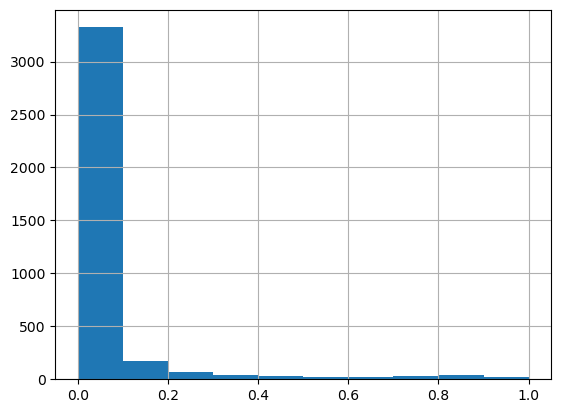

In [90]:
# We can see that there are a huge number of fields, but almost all of them are missing
# (because they are for 10-Qs or other forms)
(df_table.count(axis=0) / df_table.shape[0]).hist()

16
Index(['CIK', 'Assets', 'AssetsCurrent',
       'CashAndCashEquivalentsAtCarryingValue',
       'DeferredTaxAssetsValuationAllowance', 'IncomeTaxExpenseBenefit',
       'LiabilitiesAndStockholdersEquity', 'LiabilitiesCurrent',
       'NetCashProvidedByUsedInFinancingActivities',
       'NetCashProvidedByUsedInInvestingActivities',
       'NetCashProvidedByUsedInOperatingActivities', 'NetIncomeLoss',
       'OperatingIncomeLoss', 'RetainedEarningsAccumulatedDeficit',
       'ShareBasedCompensation', 'StockholdersEquity'],
      dtype='object')


<AxesSubplot: >

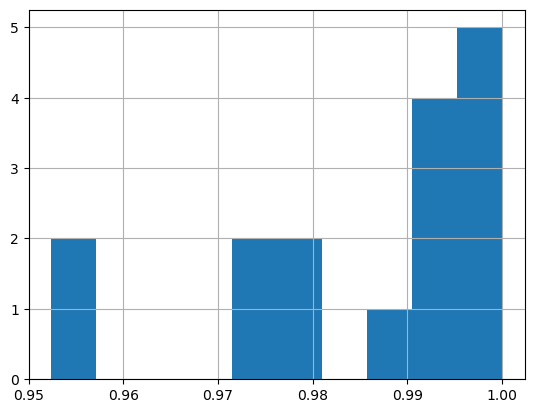

In [91]:
# What if we only took the fields that were filled out for a high percent of the companies?
FILLED_PCT_MIN = 0.95
field_filled_pct = df_table.count(axis=0) / df_table.shape[0]
df_table = df_table.loc[:, field_filled_pct >= FILLED_PCT_MIN]
print(len(df_table.columns))

# After manual inspection of these, we were reasonably happy that they captured many of the "most important" values
print(df_table.columns)

(df_table.count(axis=0) / df_table.shape[0]).hist()

# Now we rescale the data for our algorithms to work better
# df_table.hist(axis=0)

In [92]:
df_table.tail()

,CIK,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,DeferredTaxAssetsValuationAllowance,IncomeTaxExpenseBenefit,LiabilitiesAndStockholdersEquity,LiabilitiesCurrent,NetCashProvidedByUsedInFinancingActivities,NetCashProvidedByUsedInInvestingActivities,NetCashProvidedByUsedInOperatingActivities,NetIncomeLoss,OperatingIncomeLoss,RetainedEarningsAccumulatedDeficit,ShareBasedCompensation,StockholdersEquity
142,CIK0001389002,59831000.0,54014000.0,46842000.0,47915000.0,-134000.0,59831000.0,11383000.0,41479000.0,-1296000.0,-7942000.0,-12944000.0,-14062000.0,-304107000.0,2021000.0,46258000.0
143,CIK0000796343,27241000000.0,8669000000.0,3844000000.0,335000000.0,883000000.0,27241000000.0,6932000000.0,-4301000000.0,-3537000000.0,7230000000.0,4822000000.0,5802000000.0,23905000000.0,1069000000.0,14797000000.0
144,CIK0001660134,3298797000.0,2878567000.0,434607000.0,555199000.0,141000.0,3298797000.0,1545614000.0,1091598000.0,-1305146000.0,127962000.0,-266332000.0,-204159000.0,-967456000.0,196181000.0,694043000.0
145,CIK0001393052,3046067000.0,2310826000.0,730504000.0,31318000.0,13995000.0,3046067000.0,715952000.0,33818000.0,-333634000.0,551246000.0,482916000.0,476637000.0,1299656000.0,185001000.0,2266320000.0
146,CIK0001166388,3261295000.0,1277742000.0,585273000.0,22981000.0,16330000.0,3261295000.0,1163439000.0,71933000.0,-37243000.0,253846000.0,-7267000.0,108705000.0,-113797000.0,62289000.0,1267437000.0


In [93]:
(df_table.count(axis=0) / df_table.shape[0])

CIK                                           1.000000
Assets                                        1.000000
AssetsCurrent                                 1.000000
CashAndCashEquivalentsAtCarryingValue         0.972789
DeferredTaxAssetsValuationAllowance           0.979592
IncomeTaxExpenseBenefit                       0.952381
LiabilitiesAndStockholdersEquity              1.000000
LiabilitiesCurrent                            1.000000
NetCashProvidedByUsedInFinancingActivities    0.993197
NetCashProvidedByUsedInInvestingActivities    0.972789
NetCashProvidedByUsedInOperatingActivities    0.993197
NetIncomeLoss                                 0.979592
OperatingIncomeLoss                           0.993197
RetainedEarningsAccumulatedDeficit            0.993197
ShareBasedCompensation                        0.952381
StockholdersEquity                            0.986395
dtype: float64

<AxesSubplot: >

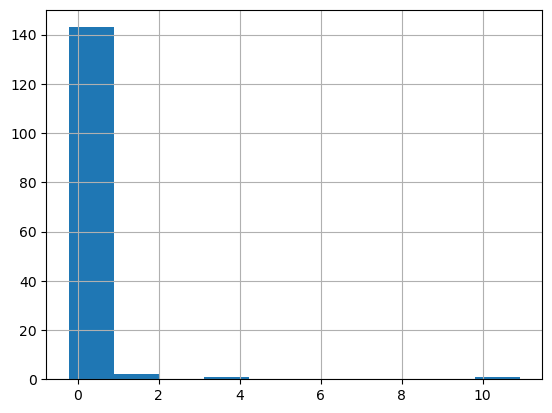

In [94]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

assert df_table.columns[0] == "CIK"
df_table.iloc[:, 1:] = sc.fit_transform(df_table.iloc[:, 1:])

df_table.head()

# FIXME: distribution is heavily skewed. Maybe use MinMax on skewed columns to deal with outliers
df_table["LiabilitiesAndStockholdersEquity"].hist()

In [95]:
df_table["CIK"] = df_table["CIK"].apply(lambda cik: int(cik[3:]))

In [96]:
## JOIN df_text and df_table on CIK

df_joined = df_text_non_tokenized.join(df_table.set_index("CIK"), on="cik", how="inner")
print(df_joined.shape)

df_joined.head()

(147, 48)


,cik,company,filing_type,filing_date,period_of_report,sic,state_of_inc,state_location,fiscal_year_end,filing_html_index,...,LiabilitiesAndStockholdersEquity,LiabilitiesCurrent,NetCashProvidedByUsedInFinancingActivities,NetCashProvidedByUsedInInvestingActivities,NetCashProvidedByUsedInOperatingActivities,NetIncomeLoss,OperatingIncomeLoss,RetainedEarningsAccumulatedDeficit,ShareBasedCompensation,StockholdersEquity
0,1614178,"Yext, Inc.",10-K,2021-03-16,2021-01-31,7374,DE,NY,0131,https://www.sec.gov/Archives/edgar/data/161417...,...,-0.193358,-0.191754,0.060791,0.230125,-0.145836,-0.141906,-0.130222,-0.173258,-0.21466,-0.171335
2,843006,ISSUER DIRECT CORP,10-K,2021-03-04,2020-12-31,2750,None,NC,1231,https://www.sec.gov/Archives/edgar/data/843006...,...,-0.211926,-0.222641,0.055407,0.254759,-0.145292,-0.119709,-0.110409,-0.083031,-0.337296,-0.185638
3,1707753,Elastic N.V.,10-K,2021-06-25,2021-04-30,7372,P7,P7,0430,https://www.sec.gov/Archives/edgar/data/170775...,...,-0.180778,-0.1687,0.073772,0.254288,-0.142543,-0.145043,-0.132927,-0.189702,-0.333603,-0.151496
5,50471,PARK CITY GROUP INC,10-K,2021-09-28,2021-06-30,7374,NV,UT,0630,https://www.sec.gov/Archives/edgar/data/50471/...,...,-0.2114,-0.222216,0.055119,0.254743,-0.145188,-0.119551,-0.110553,-0.089644,NaN,-0.184536
7,1327811,"Workday, Inc.",10-K,2021-03-02,2021-01-31,7374,DE,CA,0131,https://www.sec.gov/Archives/edgar/data/132781...,...,0.077548,0.296702,0.203739,-0.216899,0.04969,-0.187933,-0.165453,-0.583227,1.374609,0.07874


In [97]:
df_joined.shape

(147, 48)

Text(0, 0.5, 'KMeans Loss')

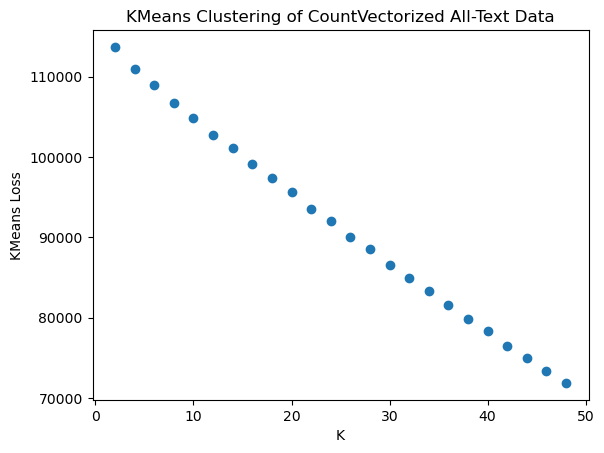

In [98]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# ANALYSIS BASELINE

# baseline: concatenate all text columns into one giant string
df_joined["all_text"] = df_joined.loc[:, text_columns].sum(axis=1)

# vectorize using Bag of Words
vec = CountVectorizer(max_df=0.95, binary=True)
X_text = vec.fit_transform(df_joined["all_text"])

losses = {}

# cluster on text ONLY
for k in range(2, 50, 2):
    km = KMeans(n_clusters=k, random_state=1).fit(X_text)
    labels = km.predict(X_text)
    losses[k] = km.inertia_

plt.scatter(losses.keys(), losses.values())
plt.title("KMeans Clustering of CountVectorized All-Text Data")
plt.xlabel("K")
plt.ylabel("KMeans Loss")

Text(0, 0.5, 'KMeans Loss')

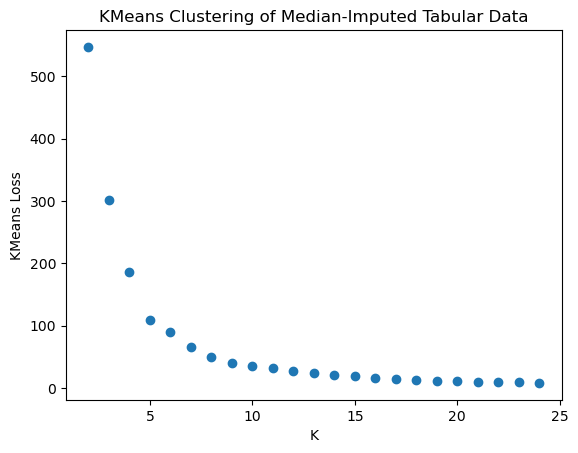

In [ ]:
from sklearn.impute import SimpleImputer

#######
# cluster on financials ONLY

# get only numerical cols
list(enumerate(df_joined.columns))
assert df_joined.columns[33] == "Assets"

simp = SimpleImputer(strategy="median")
X_table = simp.fit_transform(df_joined.iloc[:, 33:47])

losses = {}

# use kmeans
for k in range(2, 25):
    km = KMeans(n_clusters=k, random_state=1).fit(X_table)
    labels = km.predict(X_table)
    losses[k] = km.inertia_

plt.scatter(losses.keys(), losses.values())
plt.title("KMeans Clustering of Median-Imputed Tabular Data")
plt.xlabel("K")
plt.ylabel("KMeans Loss")

In [123]:
OPTIMAL_K = 6
km = KMeans(n_clusters=OPTIMAL_K, random_state=1).fit(X_table)
labels = km.predict(X_table)

cluster_0_points = set()
for i, company in enumerate(df_joined.iterrows()):
    if labels[i] == 4:  # arbitrarily get points in cluster 0
        cluster_0_points.add(company[1]["cik"])

print(cluster_0_points)

{1108524, 8670, 896878, 796343}


In [124]:
# df_table_raw["CIK"] = df_table_raw["CIK"].apply(lambda cik: int(cik[3:]))

df_table_raw.loc[df_table_raw["CIK"].isin(cluster_0_points), "Name"]
# df_table_raw["CIK"]#.isin(cluster_0_points)

20                          INTUIT INC
61                salesforce.com, inc.
73     AUTOMATIC DATA PROCESSING, INC.
143                         ADOBE INC.
Name: Name, dtype: object